In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from time import time
import seaborn as sns
e = np.exp(1)

STOP,SKIP,COMP = 0,1,2
g1,g2 = 0,1
linestyle = ["-", "--", "-.", ":"]

plt.rcParams.update(rc_fonts)

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size':12})
#rc('text', usetex=True)
%matplotlib notebook

# Defining the DynProg algorithm decision rule and its success proba

In [2]:
def getSuccessProbaB0(N,lmb1, k=g1, Bmax=0, tmin=1):
    lmb = {}
    lmb[g1] = lmb1
    lmb[g2] = 1 - lmb1

    Tvals = [t for t in range(tmin,N+1)]
    Tvals.reverse()

    # V[B,t,m,gstar]
    V = np.zeros((Bmax+1,N+2,N+1,2), dtype = "float")

    # R[ACTION][B,t,m,g]
    R = {}
    for action in [STOP,SKIP,COMP]:
        R[action] = np.zeros((Bmax+1,N+2,N+1,2), dtype = "float")

    # B = 0
    for t in Tvals:
        for m in range(t): # m = |G^k_{t-1}|
            for g in [g1,g2]:
                ng = g1 if g==g2 else g2
                
                # m(step t-1), M(step t)
                M = m + int(g==k) # = |G^k_{t}|
                
                mg,mng,Mg,Mng = 0,0,0,0
                if g == k:
                    mg,Mg = m,M
                    mng,Mng = t-1-m, t-M
                else:
                    mg,Mg = t-1-m, t-M
                    mng,Mng = m,M

                
                R[STOP][0,t,m,g] = Mg/N
                R[SKIP][0,t,m,g] = Mg/t*V[0,t+1,M,g] + Mng/t*V[0,t+1,M,ng]
                
                
                #-----------------------------------------------------------
                gstar = g
                rwd_rt1 = t/N
                if R[STOP][0,t,m,g] < R[SKIP][0,t,m,g]:
                    rwd_rt1 = V[0,t+1,M,g]
                p = 1/t
                V[0,t,m,gstar] += lmb[g] * ( p*rwd_rt1 + (1-p)*V[0,t+1,M,g] ) 
            
                #-----------------------------------------------------------
                gstar = ng
                rwd_rt1 = t/N*(mg+1)/(mg+t)
                if R[STOP][0,t,m,g] < R[SKIP][0,t,m,g]:
                    q = (mg+1)/(mg+t)
                    rwd_rt1 = q*V[0,t+1,M,g] + (1-q)*V[0,t+1,M,ng]
                p = 1/t*(1+(t-1)/(mg+1))
                V[0,t,m,gstar] += lmb[g] * ( p*rwd_rt1 + (1-p)*V[0,t+1,M,gstar] )
    V[0,0,0,g1] = lmb[g1]*V[0,1,0,g1] + lmb[g2]*V[0,1,0,g2]
    V[0,0,0,g2] = V[0,0,0,g1]
    return V,R


def theoretic(lmb):
    return lmb**2*np.exp(1/lmb-2)

In [3]:
def getSuccessProba(N, Bmax, lmb1, k=g1, tmin=1):
    lmb = {}
    lmb[g1] = lmb1
    lmb[g2] = 1 - lmb1

    Tvals = [t for t in range(tmin,N+1)]
    Tvals.reverse()

    # V[B,t,m,gstar]
    V, R = getSuccessProbaB0(N,lmb1, k=g1, Bmax=Bmax, tmin=tmin)

    for B in range(1,Bmax+1):
        for t in Tvals:
            for m in range(t): # m = |G^k_{t-1}|
                for g in [g1,g2]:
                    ng = g1 if g==g2 else g2

                    # m(step t-1), M(step t)
                    M = m + int(g==k) # = |G^k_{t}|

                    mg,mng,Mg,Mng = 0,0,0,0
                    if g == k:
                        mg,Mg = m,M
                        mng,Mng = t-1-m, t-M
                    else:
                        mg,Mg = t-1-m, t-M
                        mng,Mng = m,M

                    q = (mg+1)/(mg+t)
                    R[STOP][B,t,m,g] = Mg/N
                    R[SKIP][B,t,m,g] = Mg/t*V[B,t+1,M,g] + Mng/t*V[B,t+1,M,ng]
                    R[COMP][B,t,m,g] = Mg/N + Mng/t*( q*t/N + (1-q)*V[B-1,t+1,M,ng] )
                    
                    #-----------------------------------------------------------
                    gstar = g
                    rwd_rt1 = t/N
                    if R[COMP][B,t,m,g] < R[SKIP][B,t,m,g]:
                        rwd_rt1 = V[B,t+1,M,g]
                    p = 1/t
                    V[B,t,m,gstar] += lmb[g] * ( p*rwd_rt1 + (1-p)*V[B,t+1,M,g] ) 
                    
                    #-----------------------------------------------------------
                    gstar = ng
                    q = (mg+1)/(mg+t)
                    rwd_rt1 = q*t/N + (1-q)*V[B-1,t+1,M,ng]
                    if R[COMP][B,t,m,g] < R[SKIP][B,t,m,g]:
                        rwd_rt1 = q*V[B,t+1,M,g] + (1-q)*V[B,t+1,M,ng]
                    p = 1/t*( 1 + (t-1)/(mg+1))
                    V[B,t,m,gstar] += lmb[g] * ( p*rwd_rt1 + (1-p)*V[B,t+1,M,ng] ) 

        V[B,0,0,g1] = lmb[g1]*V[B,1,0,g1] + lmb[g2]*V[B,1,0,g2]
        V[B,0,0,g2] = V[B,0,0,g1]
    return V,R


In [248]:
V,R = getSuccessProba(100, 3, 0.7)
V[0,0,0,0]

0.2809831367542418

In [4]:
# Symmetry test
N = 50
B = 5
lmb1 = 0
V1,R1 = getSuccessProba(N,B,lmb1,k=g1)
V2,R2 = getSuccessProba(N,B,lmb1,k=g2)
print(V1[0,0,0,g1])
print(V2[1,0,0,g2])

0.3742750136479204
0.3742750136479204


# Deducing the optimal thresholds using the DP algorithm

In [4]:
def getAlphaBeta0(lmb):
    if lmb > 0.5:
        return lmb*np.exp(1/lmb-2), lmb
    else:
        return 1-lmb, (1-lmb)*np.exp(1/(1-lmb)-2)

In [5]:
def getAlphasBetas(B,lmb1,N=300,wmin=0.361):
    tmin = int(wmin*N)
    V,R = getSuccessProba(N, B, lmb1, tmin=tmin)
    acceptance = 1*(R[COMP] > R[SKIP])
    acceptance[0] = 1*(R[STOP] > R[SKIP])[0]
    alphas = np.zeros(B+1, dtype="float")
    betas  = np.zeros(B+1, dtype="float")
    
    alphas[0], betas[0] = getAlphaBeta0(lmb1)
    
    for b in range(1,B+1):
        numDetermined = 0
        for t in range(tmin,N):
            if alphas[b]==0 and acceptance[b,t,int(lmb1*t),g1]:
                alphas[b] = t/N
                numDetermined += 1
            if betas[b]==0 and acceptance[b,t,int(lmb1*t),g2]:
                betas[b] = t/N
                numDetermined += 1
            if numDetermined == 2:
                break
    return alphas, betas

# Implementing the algorithms

In [6]:
g1, g2 = 0,1

def candidateGroup(lmb):
    # Pr(g=g1) = lmb, Pr(g=g2) = 1 - lmb
    if np.random.rand() < lmb:
        return g1
    return g2

In [7]:
def singleThresh(x,B,lmb1,w):
    maxG = {g1:0, g2:0}
    N = len(x)
    for t in range(len(x)):
        # New observation --------------------------------------
        gt = candidateGroup(lmb1)
        ngt = g1 if gt==g2 else g2
        rt = int(x[t] > maxG[gt])
        # Action -----------------------------------------------
        if rt == 1:
            maxG[gt] = x[t]
            if B==0 and t/N > w:
                return t
            elif B>0 and t/N > w:
                # make a comparison
                B = B-1
                Rt = int(x[t] > maxG[ngt])
                if Rt == 1:
                    return t
    return -1

In [8]:
def dynProg(x,B,lmb1,R): # must call getSuccessProba before with k=g1
    m1 = 0
    maxG = {g1:0, g2:0}
    for t in range(1,len(x)+1):
        xt = x[t-1] # because R,V are index from 1 to N
        # New observation --------------------------------------
        gt = candidateGroup(lmb1)
        ngt = g1 if gt==g2 else g2
        rt = int(xt > maxG[gt])
        # Action -----------------------------------------------
        if rt == 1:
            maxG[gt] = xt
            if B==0 and R[STOP][0,t,m1,gt] > R[SKIP][0,t,m1,gt]:
                return t-1
            elif B>0 and R[COMP][B,t,m1,gt] > R[SKIP][B,t,m1,gt]:
                # make a comparison
                B = B-1
                Rt = int(xt > maxG[ngt])
                if Rt == 1:
                    return t-1
        m1 += int(gt==g1)
    return -1

In [9]:
def DDT(x, lmb1, alphas, betas):
    N = len(x)
    B = len(alphas)-1
    maxG = {g1:0, g2:0}
    thresh = {g1:alphas, g2:betas}
    for t in range(len(x)):
        # New observation --------------------------------------
        gt = candidateGroup(lmb1)
        ngt = g1 if gt==g2 else g2
        rt = int(x[t] > maxG[gt])
        # Action -----------------------------------------------
        if rt == 1:
            maxG[gt] = x[t]
            if B==0 and t/N > thresh[gt][0]:
                return t
            elif B>0 and t/N > thresh[gt][B]:
                # make a comparison
                B = B-1
                Rt = int(x[t] > maxG[ngt])
                if Rt == 1:
                    return t
    return -1

# The case of multiple groups

In [69]:
def computeOptThresh0(lmbK,K): 
    # K groups, one with proportion lmbK,
    # the others with equal proportion lmb st (lmbK = 1-(K-1)lmb)
    lmb = (1-lmbK)/(K-1)
    alphas = np.ones(K, dtype="float")
    if lmbK >= 1/K:
        alphas *= lmbK**(1/(K-1))
        alphas[-1] *= np.exp(lmb/lmbK - 1)
    else:
        alphas *= (1-(K-1)*lmbK)**(1/(K-1))
        alphas[:-1] /= (1 + (K-2)*(1-lmbK/lmb))**(1/(K-2)) 
    return alphas

def computeGreedyThreshB(lmbK,K,B):
    alphas = np.ones((B+1,K), dtype="float")*np.exp(-1)
    alphas[0] = computeOptThresh0(lmbK,K)
    return alphas

In [70]:
def randomGroup(p):
    return np.random.choice(len(p), p=p)

def greedyDT(x, K, B, alphas, p):
    N = len(x)
    B = len(alphas)-1
    K = len(alphas[0])
    maxG = {i:0 for i in range(K)}
    maxOverall = 0
    for t in range(len(x)):
        # New observation --------------------------------------
        gt = randomGroup(p)
        rt = int(x[t] > maxG[gt])
        # Action -----------------------------------------------
        if rt == 1:
            maxG[gt] = x[t]
            if B==0 and t/N > alphas[0][gt]:
                return t
            elif B>0 and t/N > alphas[B][gt]:
                # make a comparison
                B = B-1
                Rt = int(x[t] > maxOverall)
                if Rt == 1:
                    return t
        maxOverall = max(maxOverall, x[t])
    return -1

# Test for computing the empirircal success probability

In [88]:
def testSingleThresh(N,B,lmb1,niters=1000):
    countSuccess = 0
    for i in range(niters):
        x = np.random.rand(N)
        selected = singleThresh(x,B,lmb1,1/e)
        countSuccess += int(selected == x.argmax())
    return countSuccess/niters

def testDynProg(N,B,lmb1,niters=1000):
    V,R = getSuccessProba(N,B,lmb1)
    countSuccess = 0
    for i in range(niters):
        x = np.random.rand(N)
        selected = dynProg(x,B,lmb1,R)
        countSuccess += int(selected == x.argmax())
    return countSuccess/niters

def testOptDDT(N,B,lmb1,niters=1000): # DDT with optimal thresholds
    countSuccess = 0
    alphas, betas = getAlphasBetas(B,lmb1)
    for i in range(niters):
        x = np.random.rand(N)
        selected = DDT(x,lmb1, alphas, betas)
        countSuccess += int(selected == x.argmax())
    return countSuccess/niters

def testGreedyDTK(N,K,B,lmbK,niters=1000): # DDT with optimal thresholds
    countSuccess = 0
    alphas = computeGreedyThreshB(lmbK,K,B)
    p = np.ones(K, dtype="float")*(1-lmbK)/(K-1)
    p[-1] = lmbK
    for i in range(niters):
        x = np.random.rand(N)
        selected = greedyDT(x, K, B, alphas, p)
        countSuccess += int(selected == x.argmax())
    return countSuccess/niters

def saveToFile(arr, filename):
    with open("experiments/" + filename + ".txt", "w") as file:
        for item in arr:
            file.write(f"{item}\n")

def loadFromFile(filename):
    with open("experiments/" + filename + ".txt", "r") as file:
        loadedList = [line.strip() for line in file]
    return np.array([float(x) for x in loadedList])

In [89]:
N = 100
K = 2
B = 0
lmbK = 1/(K)
testGreedyDTK(N,K,B,lmbK, niters=100)

0.28

# Experiments

## Compute the optimal thresholds

In [ ]:
B = 3
size = 50
lmbVals = np.linspace(0.5,1,size+1)[:-1]
alphas = np.zeros((B+1,size))
betas = np.zeros((B+1,size))

ti = time()
for i in range(size):
    print("i = ",i, ",\t total time = ", (time() - ti)//60,"(min)")
    alphas[:,i], betas[:,i] = getAlphasBetas(B,lmbVals[i],N=5000)
print("total time = ", time() - ti)

In [51]:
def thresh0(l):
    return l*np.exp(1/l-2)
alphas[0] = thresh0(lmbVals)
betas[0] = lmbVals[:]

<IPython.core.display.Javascript object>


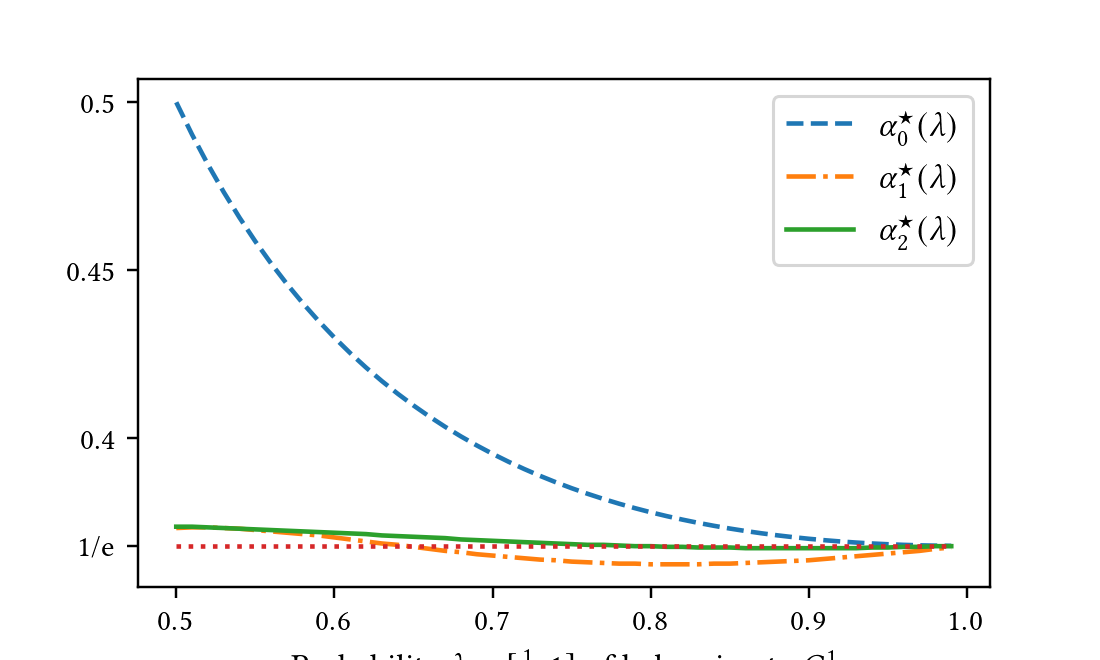

In [126]:
figure(figsize=(5,3))
linestyle = ["--","-.","-","-"]
legend = [r"$\alpha^\star_0(\lambda)$", r"$\alpha^\star_1(\lambda)$", r"$\alpha^\star_2(\lambda)$"]
for b in range(0,3):
    plt.plot(lmbVals,alphas[b], linestyle[b], label = legend[b])
    #plt.plot(lmbVals,betas[b])
plt.plot(lmbVals, 1/e*np.ones_like(lmbVals),':')
plt.xlabel(r"Probability $\lambda \in [\tfrac{1}{2},1]$ of belonging to $G^1$", fontsize=11)

yvals = [1/e,0.4,0.45,0.5]
ylabels = ["1/e", "0.4", "0.45","0.5"]
plt.yticks(yvals, ylabels)
plt.legend(fontsize=11)

plt.savefig('threshAlpha.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


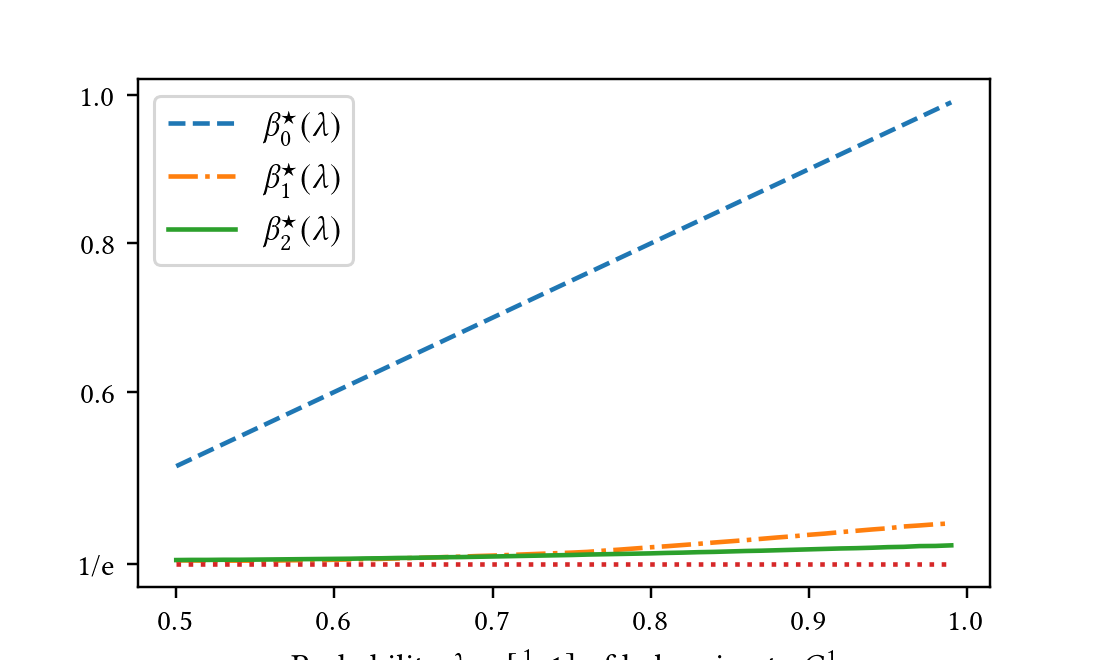

In [124]:
figure(figsize=(5,3))
linestyle = ["--","-.","-"]
legend = [r"$\beta^\star_0(\lambda)$", r"$\beta^\star_1(\lambda)$", r"$\beta^\star_2(\lambda)$"]
for b in range(0,3):
    plt.plot(lmbVals,betas[b], linestyle[b], label = legend[b])
    #plt.plot(lmbVals,betas[b])
plt.plot(lmbVals, 1/e*np.ones_like(lmbVals),':')
plt.xlabel(r"Probability $\lambda \in [\tfrac{1}{2},1]$ of belonging to $G^1$", fontsize=11)

yvals = [1/e,0.6,0.8,1]
ylabels = ["1/e", "0.6", "0.8","1.0"]
plt.yticks(yvals, ylabels)
plt.legend(fontsize=11)

plt.savefig('threshBeta.pdf', bbox_inches='tight')

## Lower bound of the corollary on the success proba

In [9]:
def S(B,w):
    logw = np.log(1/w)
    prod = 1
    sumTerms = B+1
    for l in range(1,B+1):
        prod *= logw/l
        sumTerms += (B+1-l)*prod
    return (B+1)/w - sumTerms
    
def lbPhi(alpha, beta, lmb, B):
    return lmb*alpha*np.log(beta/alpha) + alpha*beta*S(B,beta)

def getOptThresh(lmb, B):
    alpha = np.linspace(1/e,1,300)
    alphaStar = 0
    betaStar = 0
    maxProba = 0
    for a in alpha:
        beta = np.linspace(a,1,300)
        for b in beta:
            proba = lbPhi(a,b,lmb,B)
            if proba > maxProba:
                maxProba = proba 
                alphaStar = a
                betaStar = b
    return alphaStar,betaStar,maxProba

In [11]:
Bmax = 2
lmbVals = np.linspace(0.5,1,50)

alphas = np.zeros((Bmax+1,len(lmbVals)), dtype = "float")
betas = np.zeros((Bmax+1,len(lmbVals)), dtype = "float")
proba = np.zeros((Bmax+1,len(lmbVals)), dtype = "float")

ti = time()
for i in range(len(lmbVals)):
    for B in range(Bmax+1):
        alphas[B][i], betas[B][i], proba[B][i] = getOptThresh(lmbVals[i], B)
print("time = ",time() - ti)

time =  39.89840602874756


In [142]:
N = 1000
optProba = np.zeros((Bmax+1,len(lmbVals)))
ti = time()
for i in range(len(lmbVals)):
    V,R = getSuccessProba(N,Bmax,lmbVals[i],k=g1)
    for B in range(Bmax+1):
        optProba[B,i] = V[B,0,0,g1]
print("time = ",time() - ti)

time =  684.2126979827881


# Opt DT. vs DynProg

In [ ]:
lmb1 = 0.5
Nvals = [20,50,100,150,200,250,300]
Bvals = [0,1,2]
niters = 1000000
proba = np.zeros((len(Bvals),len(Nvals)), dtype="float")

ti = time()
for i in range(len(Bvals)):
    B = Bvals[i]
    print("B = ",B)
    for j in range(len(Nvals)):
        N = Nvals[j]
        print(" - N = ",Nvals[j], ", time = ",time()-ti)
        proba[i,j] = testOptDDT(N,B,lmb1,niters=niters)
    print(proba[i])

In [ ]:
DPproba = np.zeros((len(Bvals),len(Nvals)), dtype="float")
for j in range(len(Nvals)):
    print("N = ",Nvals[j])
    V,R = getSuccessProba(Nvals[j],Bvals[-1]+1,0.5,k=g1)
    for i in range(Bvals[-1]+1):
        DPproba[i,j] = V[Bvals[i],0,0,0]

<IPython.core.display.Javascript object>


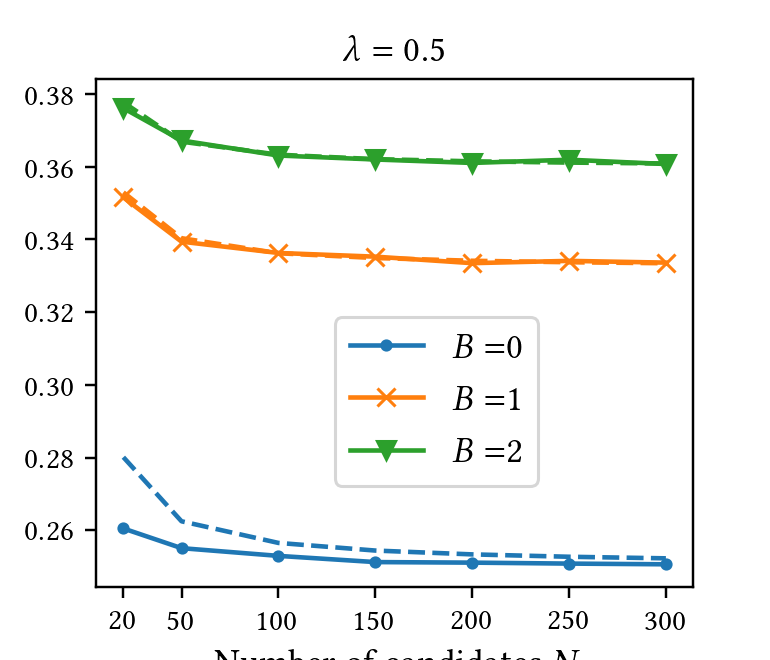

In [325]:
figure(figsize=(3.5,3))
markers = [".","x","v"]
for B in range(3):
    plt.plot(Nvals,proba[B], marker=markers[B], c="C"+str(B), label=r"$B = $" + str(B))
    plt.plot(Nvals,DPproba[B], '--', c="C"+str(B))
plt.legend(loc=(0.4,0.2), fontsize=12)
#plt.legend(fontsize=12)

xlabels = ["20","50","100","150","200","250","300"]
plt.xticks(Nvals,xlabels)

plt.xlabel(r"Number of candidates $N$", fontsize=12)
plt.title(r"$\lambda = 0.5$")


plt.savefig('DPvsDDT_05.pdf', bbox_inches='tight')

# Acceptance region of $A^*$

In [355]:
def getAcceptance(N,B,lmb1):
    V,R = getSuccessProba(N,B,lmb1)
    acceptance = 1*(R[COMP] > R[SKIP])
    acceptance[0] = 1*(R[STOP][0] > R[SKIP][0])
    a1 = acceptance[:,:,:,g1]
    a2 = acceptance[:,:,:,g2]
    return a1,a2
    

In [450]:
N = 500
B = 3
lmb1 = 0.6
a1,a2 = getAcceptance(N,B,lmb1)
alphas, betas = getAlphasBetas(B,lmb1,N=500)

<IPython.core.display.Javascript object>


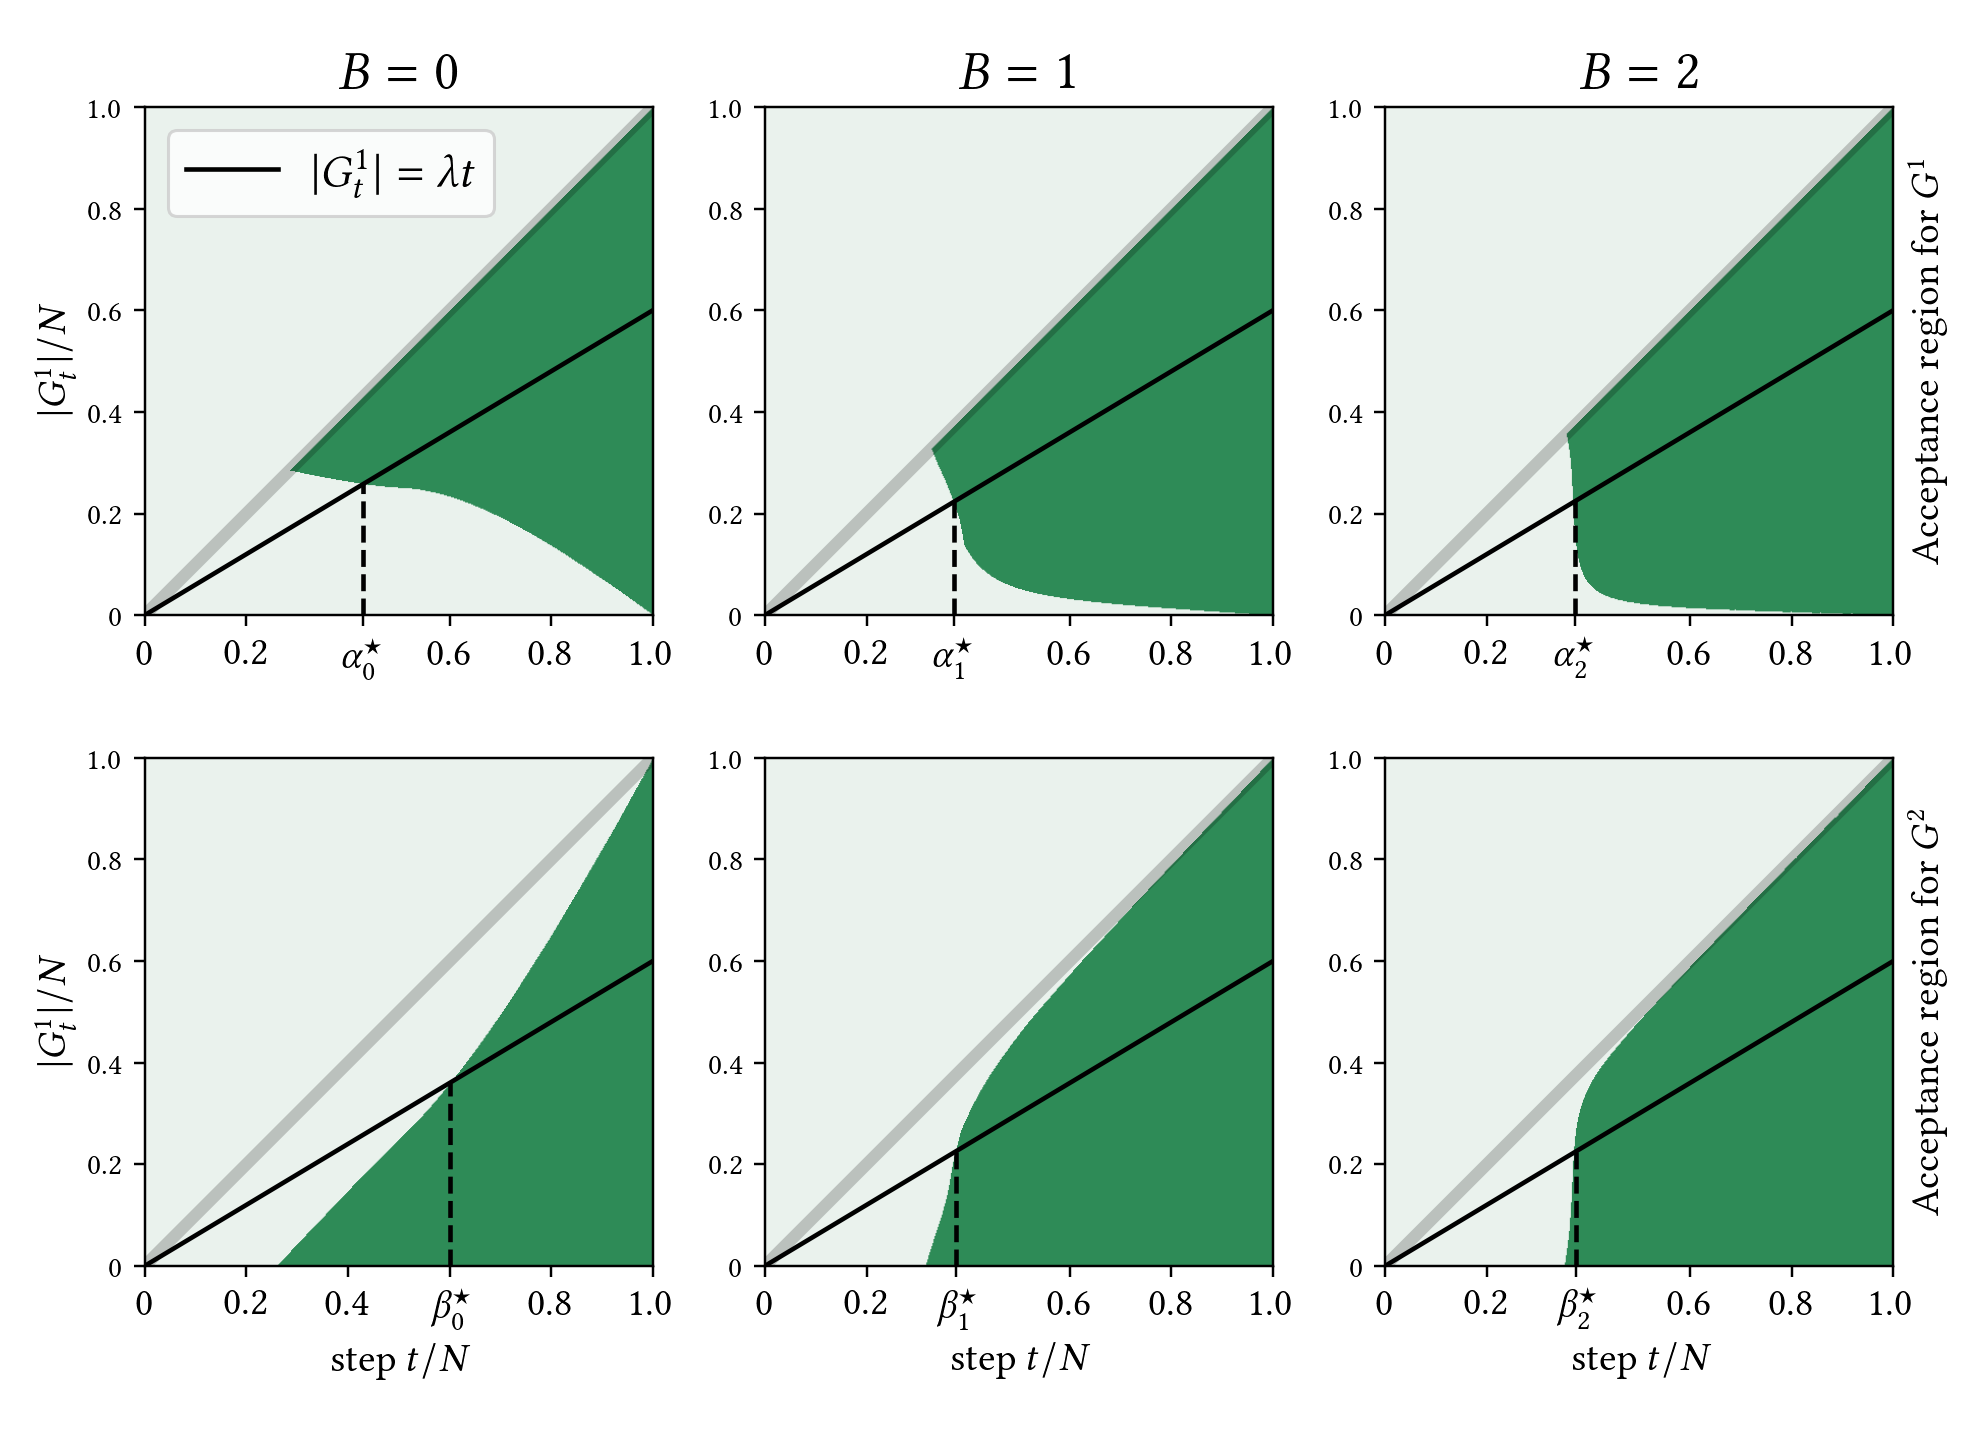

In [481]:
fig, ax = plt.subplots(2,3)
fig.set_size_inches(9,6.5)

ax[0,0].imshow(a1[0].T, cmap=sns.light_palette("seagreen", as_cmap=True))
ax[0,0].plot([0,N],[0,N], color='black', linewidth=4, alpha=0.2, zorder=10)
ax[0,0].plot([0,N],[0,lmb1*N], color='black', label="$|G^1_t| = \lambda t$")
ax[0,0].plot([alphas[0]*N, alphas[0]*N], [0, lmb1*alphas[0]*N], '--', color="black")
ax[0,0].set_title(r"$B = 0$", fontsize=18)
ax[0,0].set_ylabel(r"$|G^1_t|/N$", fontsize=13)
ax[0,0].invert_yaxis()
ax[0,0].set_xlim(0,N)
ax[0,0].set_ylim(0,N)
ax[0,0].set_xticks([0, N/5, alphas[0]*N, 3*N/5, 4*N/5, N])
ax[0,0].set_xticklabels(["0", "0.2", r"$\alpha^\star_0$", "0.6", "0.8", "1.0"], fontsize=13)
ax[0,0].set_yticks([0, N/5, 2*N/5, 3*N/5, 4*N/5, N])
ax[0,0].set_yticklabels(["0", "0.2", "0.4", "0.6", "0.8", "1.0"])
ax[0,0].legend(fontsize=15)

ax[1,0].imshow(a2[0].T, cmap=sns.light_palette("seagreen", as_cmap=True))
ax[1,0].plot([0,N],[0,N], color='black', linewidth=4, alpha=0.2, zorder=10)
ax[1,0].plot([0,N],[0,lmb1*N], color='black', label="$|G^1_t| = \lambda t$")
ax[1,0].plot([betas[0]*N, betas[0]*N], [0, lmb1*betas[0]*N], '--', color="black")
ax[1,0].set_xlabel(r"step $t/N$", fontsize=13)
ax[1,0].set_ylabel(r"$|G^1_t|/N$", fontsize=13)
ax[1,0].invert_yaxis()
ax[1,0].set_xlim(0,N)
ax[1,0].set_ylim(0,N)
ax[1,0].set_xticks([0, N/5, 2*N/5, betas[0]*N, 4*N/5, N])
ax[1,0].set_xticklabels(["0", "0.2", "0.4", r"$\beta^\star_0$", "0.8", "1.0"], fontsize=13)
ax[1,0].set_yticks([0, N/5, 2*N/5, 3*N/5, 4*N/5, N])
ax[1,0].set_yticklabels(["0", "0.2", "0.4", "0.6", "0.8", "1.0"])


# B = 1
ax[0,1].imshow(a1[1].T, cmap=sns.light_palette("seagreen", as_cmap=True))
ax[0,1].plot([0,N],[0,N], color='black', linewidth=4, alpha=0.2, zorder=10)
ax[0,1].plot([0,N],[0,lmb1*N], color='black', label="$|G^1_t| = \lambda t$")
ax[0,1].plot([alphas[1]*N, alphas[1]*N], [0, lmb1*alphas[1]*N], '--', color="black")
ax[0,1].set_title(r"$B = 1$", fontsize=18)
ax[0,1].invert_yaxis()
ax[0,1].set_xlim(0,N)
ax[0,1].set_ylim(0,N)
ax[0,1].set_xticks([0, N/5, alphas[1]*N, 3*N/5, 4*N/5, N])
ax[0,1].set_xticklabels(["0", "0.2", r"$\alpha^\star_1$", "0.6", "0.8", "1.0"], fontsize=13)
ax[0,1].set_yticks([0, N/5, 2*N/5, 3*N/5, 4*N/5, N])
ax[0,1].set_yticklabels(["0", "0.2", "0.4", "0.6", "0.8", "1.0"])


ax[1,1].imshow(a2[1].T, cmap=sns.light_palette("seagreen", as_cmap=True))
ax[1,1].plot([0,N],[0,N], color='black', linewidth=4, alpha=0.2, zorder=10)
ax[1,1].plot([0,N],[0,lmb1*N], color='black', label="$|G^1_t| = \lambda t$")
ax[1,1].plot([betas[1]*N, betas[1]*N], [0, lmb1*betas[1]*N], '--', color="black")
ax[1,1].set_xlabel(r"step $t/N$", fontsize=13)
ax[1,1].invert_yaxis()
ax[1,1].set_xlim(0,N)
ax[1,1].set_ylim(0,N)
ax[1,1].set_xticks([0, N/5, betas[1]*N, 3*N/5, 4*N/5, N])
ax[1,1].set_xticklabels(["0", "0.2", r"$\beta^\star_1$", "0.6", "0.8", "1.0"], fontsize=13)
ax[1,1].set_yticks([0, N/5, 2*N/5, 3*N/5, 4*N/5, N])
ax[1,1].set_yticklabels(["0", "0.2", "0.4", "0.6", "0.8", "1.0"])



# B = 2
ax[0,2].imshow(a1[3].T, cmap=sns.light_palette("seagreen", as_cmap=True))
ax[0,2].plot([0,N],[0,N], color='black', linewidth=4, alpha=0.2, zorder=10)
ax[0,2].plot([0,N],[0,lmb1*N], color='black', label="$|G^1_t| = \lambda t$")
ax[0,2].plot([alphas[2]*N, alphas[2]*N], [0, lmb1*alphas[2]*N], '--', color="black")
ax[0,2].set_title(r"$B = 2$", fontsize=18)
ax[0,2].set_ylabel(r"Acceptance region for $G^1$", fontsize=13)
ax[0,2].invert_yaxis()
ax[0,2].set_xlim(0,N)
ax[0,2].set_ylim(0,N)
ax[0,2].set_xticks([0, N/5, alphas[2]*N, 3*N/5, 4*N/5, N])
ax[0,2].set_xticklabels(["0", "0.2", r"$\alpha^\star_2$", "0.6", "0.8", "1.0"], fontsize=13)
ax[0,2].set_yticks([0, N/5, 2*N/5, 3*N/5, 4*N/5, N])
ax[0,2].set_yticklabels(["0", "0.2", "0.4", "0.6", "0.8", "1.0"])
ax[0,2].yaxis.set_label_position("right")


ax[1,2].imshow(a2[3].T, cmap=sns.light_palette("seagreen", as_cmap=True))
ax[1,2].plot([0,N],[0,N], color='black', linewidth=4, alpha=0.2, zorder=10)
ax[1,2].plot([0,N],[0,lmb1*N], color='black', label="$|G^1_t| = \lambda t$")
ax[1,2].plot([betas[2]*N, betas[1]*N], [0, lmb1*betas[2]*N], '--', color="black")
ax[1,2].set_xlabel(r"step $t/N$", fontsize=13)
ax[1,2].set_ylabel(r"Acceptance region for $G^2$", fontsize=13)
ax[1,2].invert_yaxis()
ax[1,2].set_xlim(0,N)
ax[1,2].set_ylim(0,N)
ax[1,2].set_xticks([0, N/5, betas[2]*N, 3*N/5, 4*N/5, N])
ax[1,2].set_xticklabels(["0", "0.2", r"$\beta^\star_2$", "0.6", "0.8", "1.0"], fontsize=13)
ax[1,2].set_yticks([0, N/5, 2*N/5, 3*N/5, 4*N/5, N])
ax[1,2].set_yticklabels(["0", "0.2", "0.4", "0.6", "0.8", "1.0"])
ax[1,2].yaxis.set_label_position("right")


fig.tight_layout()


plt.savefig('DPacceptanceRegions.pdf', bbox_inches='tight')